# Исследование рынка заведений общественного питания Москвы

## 1. Краткое описание задачи
Задача - исследовать рынок заведений общественного питания и определить целесообразность открытия робот-кафе. 

Описание файла rest_data:
* id — идентификатор объекта;
* object_name — название объекта общественного питания;
* chain — сетевой ресторан;
* object_type — тип объекта общественного питания;
* address — адрес;
* number — количество посадочных мест.

In [85]:
import pandas as pd                                             # Импортируем библиотеки
import seaborn as sns                                           
import math
import matplotlib.pyplot as plt                                
from scipy import stats as st
import numpy as np

In [86]:
display(pd.read_csv('https://code.s3.yandex.net/datasets/rest_data.csv',nrows = 5).head())         # Выведем на экран первые 5 строк 

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Проверив файлы, приходим к выводу, что файл корректно считался, коррекция разделителя столбцов не требуется.

In [87]:
rest_data = pd.read_csv('https://code.s3.yandex.net/datasets/rest_data.csv')                       # Считаем файлы

In [88]:
rest_data.info()                                                            # Выведем общую информацию
print('    Дубликатов, шт:',rest_data.duplicated().sum())                   # Выведем кол-во дубликатов
print('    Дубликатов по столбцу id, шт:',rest_data['id'].duplicated().sum()) # Выведем кол-во дубликатов
print('    Пропусков по столбцам:')
display(rest_data.isna().sum())                                             # подсчёт пропусков
#print('    Вывод статистической информации:')
#round(rest_data.describe(),2)                                             # Выведем на экран статистическую информацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB
    Дубликатов, шт: 0
    Дубликатов по столбцу id, шт: 0
    Пропусков по столбцам:


id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

Промежуточный вывод: по данным отображенной информации, данные не нуждаются в предобработке.

### 1.1. Проверка на неявные дубликаты

Определим количество неявных дубликатов по всем столбцам, кроме id и количества мест (примем, что не в одном здании не могут находится два заведения общественного питания с одинаковым названием)

In [89]:
subset_columns=['object_name', 'chain', 'object_type', 'address'] # список ключевых столбцов
print('Дубликатов:', rest_data.duplicated(subset=subset_columns).sum())

Дубликатов: 170


In [90]:
rest_data = rest_data.drop_duplicates(subset=subset_columns)
print('Дубликатов:', rest_data.duplicated(subset=subset_columns).sum())   # проверка

Дубликатов: 0


Представляется, что наличие неявных дубликатов (искаженных наименований) по столбцу с типом объектов общественного питания может негативно повлиять на итоги исследования. Проверим их наличие:

In [91]:
# При помощи метода .value_counts() возвратим перечень уникальных значений и их кол-во
display(rest_data['object_type'].value_counts())
display(rest_data['chain'].value_counts())

кафе                                 6017
столовая                             2575
ресторан                             2276
предприятие быстрого обслуживания    1891
бар                                   853
буфет                                 571
кафетерий                             393
закусочная                            348
магазин (отдел кулинарии)             272
Name: object_type, dtype: int64

нет    12245
да      2951
Name: chain, dtype: int64

Промежуточный вывод: похожих наименований (с ошибках) не выявлено. 

Для дальнейшего компактного построения графиков, наименование заведений "предприятие быстрого обслуживания" и "магазин (кулинария)" заменим на более краткие синонимы - фастфуд и кулинария:

In [92]:
rest_data['object_type'] = rest_data['object_type'].replace('предприятие быстрого обслуживания','фастфуд')
rest_data['object_type'] = rest_data['object_type'].replace('магазин (отдел кулинарии)','кулинария')
display(rest_data['object_type'].value_counts())

кафе          6017
столовая      2575
ресторан      2276
фастфуд       1891
бар            853
буфет          571
кафетерий      393
закусочная     348
кулинария      272
Name: object_type, dtype: int64

Промежуточный вывод: выявленные неявные дубликаты, удалены. Можно приступать к анализу.

## 2. АНАЛИЗ

### 2.1. Соотношение видов объектов общественного питания по количеству

In [93]:
df_type = rest_data.groupby('object_type').agg({'object_type':'count'})
df_type.columns=['Количество']
df_type=df_type.sort_values(by='Количество',ascending=False)


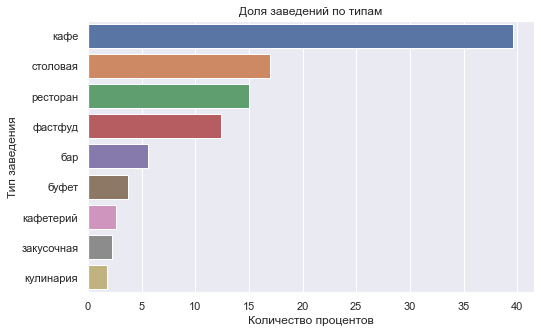

In [94]:
df_type_ = df_type.reset_index()
df_type_.columns=['Тип','Количество']
df_type_['Количество'] = round(df_type_['Количество']/sum(df_type_['Количество'])*100,2)

sns.set(rc = {'figure.figsize':(8,5)})
test = sns.barplot(y='Тип',x='Количество',data = df_type_)
test.set_title('Доля заведений по типам')
test.set_ylabel('Тип заведения')
test.set_xlabel('Количество процентов')
plt.show()

Промежуточный вывод: график с соотношением количества заведений по их типам заведений общественного питания построен. По типу приеобладают кафе и столовые.

### 2.2. Соотношение сетевых и несетевых объектов общественного питания

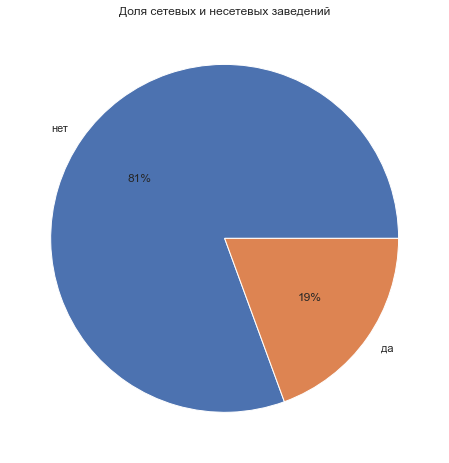

In [95]:
df_chain_store = rest_data.groupby('chain').agg({'chain':'count'})
df_chain_store.columns=['Количество']
df_chain_store=df_chain_store.sort_values(by='Количество',ascending=False)
df_chain_store['Количество'].plot(title='Доля сетевых и несетевых заведений',kind='pie', figsize=(8,8),autopct='%.0f%%')
plt.ylabel('')
plt.show()

Промежуточный вывод: круговой график с долей сетевых и несетевых заведений построен. Доля сетевых заведений составляет 19% от общего количества.

### 2.3. Типы объектов общепита с сетевым распрастранением

In [96]:
df_chain_type = rest_data[rest_data['chain']=='да']
df_chain_type = df_chain_type.groupby('object_type').agg({'object_type':'count'})
df_chain_type.columns=['в т.ч. сетевые']
df_chain_type=df_type.join(df_chain_type)
df_chain_type['%'] = round(df_chain_type['в т.ч. сетевые']/df_chain_type['Количество']*100,2)
df_chain_type=df_chain_type.sort_values(by='%',ascending=False)
df_chain_type

,Количество,в т.ч. сетевые,%
object_type,,,
фастфуд,1891,784,41.46
кулинария,272,78,28.68
ресторан,2276,542,23.81
кафе,6017,1389,23.08
закусочная,348,56,16.09
кафетерий,393,51,12.98
бар,853,37,4.34
буфет,571,11,1.93
столовая,2575,3,0.12


Промежуточный вывод: построена таблица с величиной сетевых заведений. В Топ-3 попали такие заведения, как предприятия быстрого обслуживания (41,46% из них сетевые), кулинарии (28,68%) и рестораны (23,81 %).

### 2.4. Характерное количество мест и количество сетевых заведений

,кол-во заведений,мест в среднем
object_name,,
KFC,155,55.341935
Шоколадница,139,56.762590
Бургер Кинг,121,45.272727
Макдоналдс,119,82.924370
Домино'с Пицца,86,18.209302
Теремок,84,25.047619
Крошка Картошка,82,22.963415
Милти,65,1.430769
Суши Wok,61,7.131148


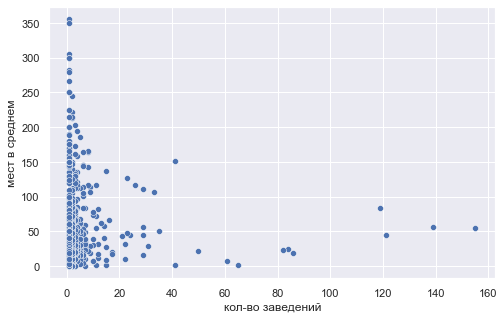

In [97]:
df_chain_number_yes = rest_data[rest_data['chain']=='да']
df_chain_number_yes = df_chain_number_yes.groupby('object_name').agg({'number':['count','mean']})
df_chain_number_yes.columns=['кол-во заведений','мест в среднем']
df_chain_number_yes = df_chain_number_yes.sort_values(by='кол-во заведений',ascending=False)
display(df_chain_number_yes.head(10))

#plt.figure(figsize=(6, 7))
sns.scatterplot(x= 'кол-во заведений', y= 'мест в среднем', data = df_chain_number_yes)
plt.show()

Промежуточный вывод: по точечному графику видно, что сети общественного питания с большим количеством заведений (более 50 шт), то есть получившие распространение и, вероятно, имеющие успех, имеют посадочных мест в среднем до 60 единиц.
Заведения общественного питания, заявленные как сетевые, с количеством посадочных мест более 150, как правило, не получили большого распространения (1,2, редко 5 заведений, но не более 10).

### 2.5. Среденее количество посадочных мест по видам заведений

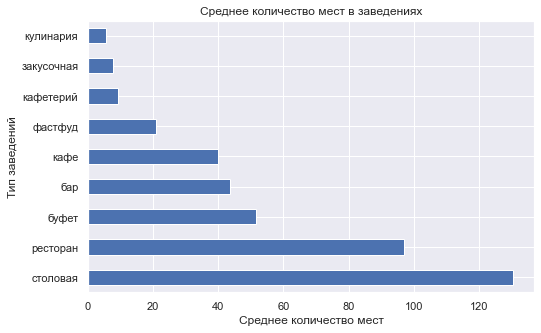

In [98]:
df_count = rest_data.groupby('object_type').agg({'number':'mean'}).sort_values(by='number',ascending=False)
df_count = round(df_count,2)
df_count
df_count.plot(kind='barh',grid=True,title='Среднее количество мест в заведениях',figsize=(8,5), legend=False)
plt.ylabel('Тип заведений')
plt.xlabel('Среднее количество мест')
plt.show()

Промежуточный вывод: график с указанием среднего количества мест в заведениях построен. Лидируют столовые и рестораны.

### 2.6. Выделение в отдельный столбец информации об улицах из столбца adress

In [99]:
def street(address):                                     # Создадим функцию, которая
    if address[0:14] == 'город Москва, ':                # если строка начинается с "город Москва, " (для большинства строк)
        address = address[14:]                           # вырежет эти символы, и затем 
    address = address[:address.find(',')]                # обрежет хвост после запятой
    return address
rest_data['street'] = rest_data['address'].apply(street)
rest_data.head()

,id,object_name,chain,object_type,address,number,street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


Промежуточный вывод: наименование улицы добавлено в столбец "street"


### 2.7. Добавление района по названию улицы

Выведем на экран первые строки, чтобы убедится в правильности формата найденного файла:

In [100]:
pd.read_csv('http://94.103.87.149/files/mosgaz-streets.csv',nrows = 5).head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


In [101]:
street_data = pd.read_csv('http://94.103.87.149/files/mosgaz-streets.csv')
street_data = street_data[['streetname','area']]
street_data.columns=['street','area']
street_data.head()

,street,area
0,Выставочный переулок,Пресненский район
1,улица Гашека,Пресненский район
2,Большая Никитская улица,Пресненский район
3,Глубокий переулок,Пресненский район
4,Большой Гнездниковский переулок,Пресненский район


Добавим наименование района к первому датафрейму:

In [102]:
rest_data = rest_data.merge(street_data,on='street',how='left')
rest_data['area'] = rest_data['area'].fillna('неизвестный')
rest_data.head()

,id,object_name,chain,object_type,address,number,street,area
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,Ярославский Район
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,Таганский район
2,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,Нижегородский район
3,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,Район Южное Бутово
4,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица,Таганский район


Уберем дубликаты, образовавшиеся из-за пересечения длинными улицами нескольких районов:

In [103]:
print(len(rest_data))
rest_data = rest_data.drop_duplicates(subset=['object_name', 'chain', 'object_type', 'address', 'number'])
print(len(rest_data))

30105
15196


### 2.8. Построить график топ-10 улиц по количеству объектов общественного питания

In [104]:
count_street = rest_data['street'].value_counts()#.reset_index()
top10_street = count_street[0:10] 

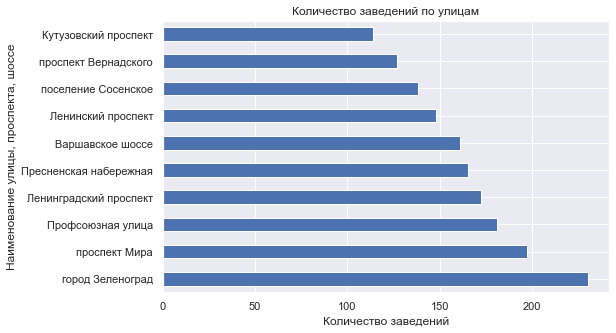

In [105]:
top10_street.plot(kind='barh',grid=True,title='Количество заведений по улицам',figsize=(8,5))
plt.ylabel('Наименование улицы, проспекта, шоссе')
#plt.xticks(rotation = 90)
plt.xlabel('Количество заведений')
plt.show()

In [106]:
pivot_table_top = rest_data.pivot_table(index=['street','area'],values='id',aggfunc='count').sort_values(by='id',ascending=False)
display(pivot_table_top.head(10))

,,id
street,area,
город Зеленоград,Район Крюково,230
проспект Мира,Алексеевский район,197
Профсоюзная улица,Академический район,181
Ленинградский проспект,Район Аэропорт,172
Пресненская набережная,Пресненский район,165
Варшавское шоссе,Район Чертаново Центральное,161
Ленинский проспект,Район Проспект Вернадского,148
поселение Сосенское,неизвестный,138
проспект Вернадского,Район Проспект Вернадского,127


Промежуточный вывод: график с десятью улицами, на которых расположено наибольшее количество заведений общественного питания, построен.

Все эти улицы связывают центр Москвы с пригородами, следовательно по ним происходит наибольший поток пассажиров.
Эти улицы расположены в разных районах

### 2.9. Отразить количество улиц с одним объектом общественного питанияи определить в каких районах они находятся

In [107]:
pivot_table_atop = rest_data.pivot_table(index=['street','area'],values='id',aggfunc='count').sort_values(by='id')
small_street = pivot_table_atop[pivot_table_atop['id']==1]
print('Количество улиц с одним заведением:',len(small_street))
display(small_street.head(10))

Количество улиц с одним заведением: 541


,,id
street,area,
Малый Толмачёвский переулок,Район Якиманка,1
Тенистый проезд,Район Свиблово,1
Театральная аллея,Район Аэропорт,1
Таёжная улица,Лосиноостровский район,1
Егорьевский проезд,Район Люблино,1
Тарханская улица,Район Выхино-Жулебино,1
Елоховский проезд,Басманный район,1
Тарусская улица,Район Ясенево,1
улица Сайкина,Даниловский район,1


In [108]:
count_street_ = pivot_table_top.reset_index()
count_street_ = count_street_['area'].value_counts()
count_street_.head(10)

Тверской район         90
Пресненский район      83
Таганский район        82
неизвестный            73
Басманный район        72
Район Хамовники        62
Район Замоскворечье    46
Даниловский район      40
Район Арбат            33
Район Сокольники       33
Name: area, dtype: int64

Промежуточный вывод: количество улиц с одним заведением общественного питания составляет 541. Судя на общедоступным данным, эти улицы расположены в разных районах Москвы (в том числе в центре), но все эти улицы очень короткие, буквально с несколькими домами. Больше всего коротких улиц с одним кафе именно в центральной (исторической) части города.

## 3. Выводы

* Открывать новое кафе целесообразно в местах с большим потоком людей, в том числе на центральных проспектах (по примеру указанных в исследовании улиц с наибольшим количеством заведений), но не ограничиваясь ими.
* Идея с обслуживанием роботами-официантами будет иметь успех в перспективе в том случае, если внедряемое нововведение позволит снизить стоимость предоставляемой услуги за счет меньших затрат на зарплату или улучшить качество обслуживания (продукции).
* Среди представленных типов заведений общественного питания более предпочтительными являются заведения, где количество посадочных мест не превышает 60 единиц, именно такие заведения получают распространение. 
* Для робот-кафе целесообразно использовать помещения с минимальным количеством мест (для снижения занимаемой площади и арендной платы). К таким видам заведений относятся, прежде всего, предприятия быстрого обслуживания (фастфуды) и кафе.
* С учетом вышесказанного, может быть рассмотрен вариант открытия автоматизированных точек (по типу киосков) в стиле хай-тек со стеклянными стенами по продаже блинов с начинкой, поскольку процесс их приготовления легко автоматизируется, занимает мало места, и за счет отсутствия персонала их себестоимость будет минимальной, такие точки могут действительно держать конкуренцию по сравнению с другими заведениями, риски по возникновению критической ситуации с загрязнением мусором и отходами, с которыми не справятся роботы, минимальные.

Презентация: https://disk.yandex.ru/i/Sfl1BFJMI6fKRg